<a href="https://colab.research.google.com/github/SheshamJoseph/malaria_detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Detection

## Preprocess the data

### Fetching the data

In [1]:
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2025-08-08 21:12:05--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.32, 3.167.192.56, 3.167.192.60, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  49.6MB/s    in 7.4s    

2025-08-08 21:12:13 (45.6 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [2]:
# unzip the files
import zipfile
zip_ref = zipfile.ZipFile('/content/cell_images.zip')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Perform OS walk through directory and list number of files
import os

for dirpath, dirnames, filenames in os.walk('/content/cell_images'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/cell_images
There are 0 directories and 13780 images in /content/cell_images/Parasitized
There are 0 directories and 13780 images in /content/cell_images/Uninfected


###  Visualize images

In [4]:
# setting class names
import pathlib
import numpy as np

data_dir = pathlib.Path('/content/cell_images')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Parasitized' 'Uninfected']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class

    # get random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # read and plot image
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    # print image shape
    print(f'Image shape: {img.shape}')

    return img

Image shape: (130, 136, 3)


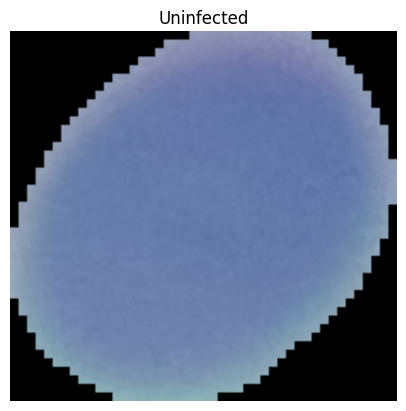

In [6]:
# view random image
target_class = random.choice(class_names)
img = view_random_image(target_dir='/content/cell_images/', target_class=target_class)

In [7]:
img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

### Loading and preparing dataset

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_SIZE = (224, 224)  # Suitable for ResNet50, VGG16, etc.
BATCH_SIZE = 32

# Path to your dataset folder
DATASET_DIR = 'cell_images/'

# Training generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split is handled here
)

# Validation generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Model building

### Creating callbacks

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

### Squeezenet model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def fire_module(x, squeeze_filters, expand_filters):
    # Squeeze layer
    squeeze = layers.Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    squeeze = layers.BatchNormalization()(squeeze)
    squeeze = layers.Activation('relu')(squeeze)

    # Expand layers
    expand_1x1 = layers.Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand_1x1 = layers.BatchNormalization()(expand_1x1)
    expand_1x1 = layers.Activation('relu')(expand_1x1)

    expand_3x3 = layers.Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
    expand_3x3 = layers.BatchNormalization()(expand_3x3)
    expand_3x3 = layers.Activation('relu')(expand_3x3)

    # Concatenate expand layers
    output = layers.concatenate([expand_1x1, expand_3x3], axis=-1)
    return output

def squeezenet_base(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Add fire modules
    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 64, 256)

    return input_layer, x

In [11]:
# build model

IMAGE_SHAPE = (224, 224, 3)

input_layer, x = squeezenet_base(IMAGE_SHAPE)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

fine_tuned_model = Model(inputs=input_layer, outputs=output_layer)

In [12]:
for layer in fine_tuned_model.layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=conv2d, built=True>
<MaxPooling2D name=max_pooling2d, built=True>
<Conv2D name=conv2d_1, built=True>
<BatchNormalization name=batch_normalization, built=True>
<Activation name=activation, built=True>
<Conv2D name=conv2d_2, built=True>
<Conv2D name=conv2d_3, built=True>
<BatchNormalization name=batch_normalization_1, built=True>
<BatchNormalization name=batch_normalization_2, built=True>
<Activation name=activation_1, built=True>
<Activation name=activation_2, built=True>
<Concatenate name=concatenate, built=True>
<Conv2D name=conv2d_4, built=True>
<BatchNormalization name=batch_normalization_3, built=True>
<Activation name=activation_3, built=True>
<Conv2D name=conv2d_5, built=True>
<Conv2D name=conv2d_6, built=True>
<BatchNormalization name=batch_normalization_4, built=True>
<BatchNormalization name=batch_normalization_5, built=True>
<Activation name=activation_4, built=True>
<Activation name=activation_5, built=True>
<Concatenate

In [13]:
fine_tuned_model.layers[1]

<Conv2D name=conv2d, built=True>

In [14]:
# fine_tuned_model.layers[1].trainable = True  # Fine-tune the base model

In [15]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

# compile model
fine_tuned_model.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', 'precision', 'recall']
)

In [16]:
fine_tuned_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │     14,208 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      1,552 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │      1,088 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │      9,280 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 55, 55,    │          0 │ activation_1[0][… │
│ (Concatenate)       │ 128)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      2,064 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 55, 55,    │      1,088 │ activation_3[0][

 Total params: 747,457 (2.85 MB)

 Trainable params: 741,697 (2.83 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [17]:
# fit model_1
fine_tuned_model_history = fine_tuned_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8585 - loss: 0.3286 - precision: 0.8313 - recall: 0.9059
Epoch 1: val_accuracy improved from -inf to 0.87387, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 303s 392ms/step - accuracy: 0.8586 - loss: 0.3284 - precision: 0.8314 - recall: 0.9059 - val_accuracy: 0.8739 - val_loss: 0.3251 - val_precision: 0.8019 - val_recall: 0.9931 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9392 - loss: 0.1884 - precision: 0.9160 - recall: 0.9674
Epoch 2: val_accuracy improved from 0.87387 to 0.88058, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 296s 382ms/step - accuracy: 0.9392 - loss: 0.1884 - precision: 0.9160 - recall: 0.9674 - val_accuracy: 0.8806 - val_loss: 0.3063 - val_precision: 0.8123 - val_recall: 0.9898 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9448 - loss: 0.1725 - precision: 0.9254 - recall: 0.9

In [19]:
fine_tuned_model.evaluate(val_generator)

173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9196 - loss: 0.1870 - precision: 0.3958 - recall: 0.4836


[0.1600666046142578, 0.9390199780464172, 0.918367326259613, 0.963702380657196]

In [20]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

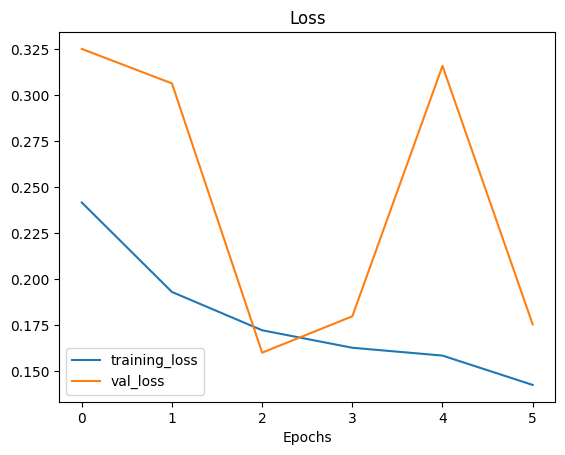

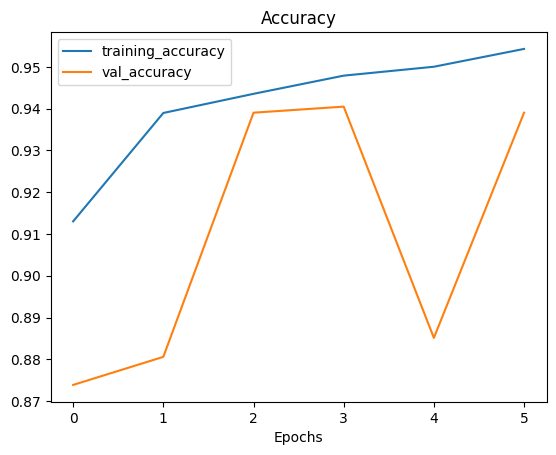

In [21]:
plot_loss_curves(fine_tuned_model_history)

In [38]:
# function to load random image from directory and pass to model for prediction

def plot_and_predict(model, filepath, class_names):
  """
  Imports an image located at filepath, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = tf.io.read_file(filepath)
  img = tf.image.decode_image(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize image to match model input shape
  img = tf.image.resize(img, size=IMAGE_SIZE)
#   img = img/255.0


  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


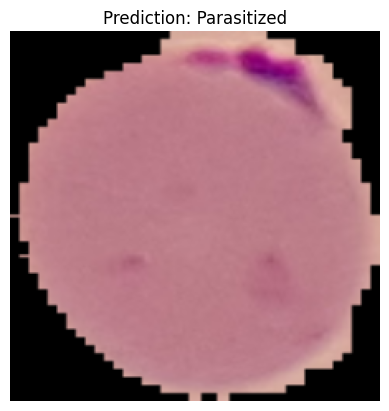

In [46]:
target_class = random.choice(class_names)
target_dir='/content/cell_images/'
target_folder = target_dir + target_class
random_image = random.sample(os.listdir(target_folder), 1)
random_image_path = target_folder + '/' + random_image[0]

# plot
plot_and_predict(fine_tuned_model, random_image_path, class_names)

In [50]:
# save the model
fine_tuned_model.save('fine_tuned_model.keras')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [32]:
# save the model
fine_tuned_model.save('co')